In [18]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import openpyxl
import matplotlib.pyplot as plt

def getdata(country,city):
# Define the start and end dates for the query
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(weeks=104)

    # Convert the dates to ISO format
    end_date_str = end_date.isoformat() + 'Z'
    start_date_str = start_date.isoformat() + 'Z'

    # Set the API endpoint and parameters
    url = 'https://api.openaq.org/v2/measurements'
    params = {
        'country': country,
        'city': city,
        'date_from': start_date_str,
        'date_to': end_date_str,
        'limit': 1, # Increase limit to get all results
        'parameter' : [1,2,3,5]
    }

    # Send the request and get the response
    response = requests.get(url, params=params)

    # Extract the relevant data and create a pandas DataFrame
    data = response.json()['results']
    print(data)
    df = pd.DataFrame({
        'location' : [d['location'] for d in data],
        'date': [d['date']['utc'] for d in data],
        'country': [d['country'] for d in data],
        'city': [d['city'] for d in data],
        'parameter_name': [d['parameter'] for d in data],
        'parameter_value': [d['value'] for d in data]
    })
    
    print(response.headers)
    

    return df
df = getdata("PL","Żary")
df
# df.to_excel(r"C:/Users/Admin/Desktop/df.xlsx")



[{'locationId': 9042, 'location': 'Żary, ul. Szymanowskiego ', 'parameter': 'no2', 'value': 6.93829, 'date': {'utc': '2023-03-04T20:00:00+00:00', 'local': '2023-03-04T21:00:00+01:00'}, 'unit': 'µg/m³', 'coordinates': {'latitude': 51.642656, 'longitude': 15.127808}, 'country': 'PL', 'city': 'Żary', 'isMobile': False, 'isAnalysis': False, 'entity': 'government', 'sensorType': 'reference grade'}]
{'Content-Type': 'application/json', 'Content-Length': '494', 'Connection': 'keep-alive', 'Date': 'Sat, 04 Mar 2023 21:20:51 GMT', 'Cache-Control': 'public, max-age=900', 'Apigw-Requestid': 'BRln6j0ToAMEYEg=', 'X-Cache': 'Miss from cloudfront', 'Via': '1.1 1c6954b6a2b349a78fb0daa669c3e984.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'VIE50-P1', 'X-Amz-Cf-Id': 'f9Q_0Y_rq_9pm9GN7gh_8QellAiqWRKJXmbQbzoGje8dq8ATlhFUMQ=='}


,location,date,country,city,parameter_name,parameter_value
0,"Żary, ul. Szymanowskiego",2023-03-04T20:00:00+00:00,PL,Żary,no2,6.93829


In [4]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Create a pivot table to group by location, date and parameter_name
pivot_df = df.pivot_table(index=['location', 'date'], columns='parameter_name', values='parameter_value', aggfunc='first')

# Reset index to convert MultiIndex to columns
pivot_df = pivot_df.reset_index()

# Print the resulting DataFrame
pivot_df



parameter_name,location,date,no2,o3,pm10,pm25
0,"Żary, ul. Szymanowskiego",2022-09-21 06:00:00+00:00,15.84140,13.7194,11.15380,5.76730
1,"Żary, ul. Szymanowskiego",2022-09-21 07:00:00+00:00,12.40240,16.1606,8.05386,6.06244
2,"Żary, ul. Szymanowskiego",2022-09-21 08:00:00+00:00,10.05340,20.2517,5.90748,7.93706
3,"Żary, ul. Szymanowskiego",2022-09-21 09:00:00+00:00,7.37119,31.7944,8.30178,5.39430
4,"Żary, ul. Szymanowskiego",2022-09-21 10:00:00+00:00,5.79158,39.9628,6.80010,5.56991
...,...,...,...,...,...,...
3424,"Żary, ul. Szymanowskiego",2023-03-04 15:00:00+00:00,6.19255,73.2872,12.27800,5.81545
3425,"Żary, ul. Szymanowskiego",2023-03-04 16:00:00+00:00,5.70313,76.5278,10.45540,5.99772
3426,"Żary, ul. Szymanowskiego",2023-03-04 17:00:00+00:00,5.26196,77.1378,13.99430,7.31791
3427,"Żary, ul. Szymanowskiego",2023-03-04 18:00:00+00:00,5.88298,74.4267,13.76950,8.64779


In [8]:
# clean_df = pivot_df.transform(lambda x:x.fillna(x.mean()))
# clean_df['date'] = pivot_df['date']
clean_df = pivot_df.dropna()

In [9]:
clean_df.isna().any().sum()

0

In [10]:
# clean_df['date']=clean_df['date'].apply(pd.to_datetime)
# clean_df.set_index("date",inplace=True)
clean_df['location'].value_counts()


Żary, ul. Szymanowskiego     2849
Name: location, dtype: int64

In [529]:
# Define the pollutant breakpoints
pollutant_breakpoints = {
    'co': [
        {'min': 0, 'max': 5000, 'I_low': 0, 'I_high': 50},
        {'min': 5000, 'max': 10000, 'I_low': 51, 'I_high': 100},
        {'min': 10000, 'max': 30000, 'I_low': 101, 'I_high': 150},
        {'min': 30000, 'max': 70000, 'I_low': 151, 'I_high': 200},
        {'min': 70000, 'max': 100000, 'I_low': 201, 'I_high': 300},
        {'min': 100000, 'max': 130000, 'I_low': 301, 'I_high': 400},
        {'min': 130000, 'max': float('inf'), 'I_low': 401, 'I_high': 500},
    ],
    'no2': [
        {'min': 0, 'max': 25, 'I_low': 0, 'I_high': 50},
        {'min': 25, 'max': 50, 'I_low': 51, 'I_high': 100},
        {'min': 50, 'max': 100, 'I_low': 101, 'I_high': 150},
        {'min': 100, 'max': 200, 'I_low': 151, 'I_high': 200},
        {'min': 200, 'max': 400, 'I_low': 201, 'I_high': 300},
        {'min': 400, 'max': 1000, 'I_low': 301, 'I_high': 400},
        {'min': 1000, 'max': float('inf'), 'I_low': 401, 'I_high': 500},
    ],
    'o3': [
        {'min': 0, 'max': 60, 'I_low': 0, 'I_high': 50},
        {'min': 60, 'max': 120, 'I_low': 51, 'I_high': 100},
        {'min': 120, 'max': 180, 'I_low': 101, 'I_high': 150},
        {'min': 180, 'max': 240, 'I_low': 151, 'I_high': 200},
        {'min': 240, 'max': 300, 'I_low': 201, 'I_high': 300},
        {'min': 300, 'max': 384, 'I_low': 301, 'I_high': 400},
        {'min': 384, 'max': float('inf'), 'I_low': 401, 'I_high': 500}],
    'pm10': [
        {'min': 0, 'max': 20, 'I_low': 0, 'I_high': 50},
        {'min': 20, 'max': 40, 'I_low': 51, 'I_high': 100},
        {'min': 40, 'max': 50, 'I_low': 101, 'I_high': 150},
        {'min': 50, 'max': 100, 'I_low': 151, 'I_high': 200},
        {'min': 100, 'max': 150, 'I_low': 201, 'I_high': 300},
        {'min': 150, 'max': 200, 'I_low': 301, 'I_high': 400},
        {'min': 200, 'max': float('inf'), 'I_low': 401, 'I_high': 500}],
    'pm25': [
        {'min': 0, 'max': 15, 'I_low': 0, 'I_high': 50},
        {'min': 15, 'max': 30, 'I_low': 51, 'I_high': 100},
        {'min': 30, 'max': 55, 'I_low': 101, 'I_high': 150},
        {'min': 55, 'max': 110, 'I_low': 151, 'I_high': 200},
        {'min': 110, 'max': 150, 'I_low': 201, 'I_high': 300},
        {'min': 150, 'max': 200, 'I_low': 301, 'I_high': 400},
        {'min': 200, 'max': float('inf'), 'I_low': 401, 'I_high': 500}], ## made changes from what chat said to what is in wiki 
    'so2': [
        {'min': 0, 'max': 50, 'I_low': 0, 'I_high': 50},
        {'min': 50, 'max': 100, 'I_low': 51, 'I_high': 100},
        {'min': 100, 'max': 200, 'I_low': 101, 'I_high': 150},
        {'min': 200, 'max': 350, 'I_low': 151, 'I_high': 200},
        {'min': 350, 'max': 500, 'I_low': 201, 'I_high': 300},
        {'min': 500, 'max': 750, 'I_low': 301, 'I_high': 400},
        {'min': 750, 'max': float('inf'), 'I_low': 401, 'I_high': 500}]
    }

def calculate_AQI(pollutant, value):
    """
    Calculates the Air Quality Index (AQI) for a given pollutant and its concentration value.
    """
    breakpoints = pollutant_breakpoints[pollutant]
    
    for i in range(len(breakpoints)):
        if value >= breakpoints[i]['min'] and value <= breakpoints[i]['max']:
            C_low = breakpoints[i]['min']
            C_high = breakpoints[i]['max']
            I_low = breakpoints[i]['I_low']
            I_high = breakpoints[i]['I_high']
            AQI = ((I_high - I_low) / (C_high - C_low)) * (value - C_low) + I_low
            return AQI
    
    raise ValueError('Invalid pollutant or value.')



In [530]:
num = len(clean_df.columns[2:])
for name in clean_df.columns[2:]:
    
    clean_df[f'{name}_SubIndex'] = clean_df[name].apply(lambda x: calculate_AQI(f'{name}', x))

# clean_df['NO2_SubIndex'] = clean_df['no2'].apply(lambda x: calculate_AQI('NO2',x))
# # clean_df['O3_SubIndex'] = clean_df['o3'].apply(lambda x: calculate_AQI('O3',x))
# clean_df['PM10_SubIndex'] = clean_df['pm10'].apply(lambda x: calculate_AQI('PM10',x))
# clean_df['PM25_SubIndex'] = clean_df['pm25'].apply(lambda x: calculate_AQI('PM25',x))
# # clean_df['SO2_SubIndex'] = clean_df['so2'].apply(lambda x: calculate_AQI('SO2',x))

num

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


4

In [531]:
import numpy as np
clean_df
clean_df["AQI"] = np.nan
clean_df.columns

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Index(['location', 'date', 'no2', 'o3', 'pm10', 'pm25', 'no2_SubIndex',
       'o3_SubIndex', 'pm10_SubIndex', 'pm25_SubIndex', 'AQI'],
      dtype='object', name='parameter_name')

In [532]:
clean_df
colnames = clean_df.columns[num+2:-1]


In [533]:
clean_df["AQI"] = clean_df["AQI"].fillna(round(clean_df[[*colnames]].max(axis=1)))


clean_df.columns.name = None


clean_df = clean_df.groupby(['date'],as_index=False).mean()
clean_df = clean_df.set_index('date')





C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [535]:
from statsmodels.tsa.stattools import adfuller
def test(df):
    df_test = adfuller(df,autolag='AIC')
    print("p value",df_test[1])

test(clean_df['no2'])


p value 0.07919907794609599


In [536]:
clean_df

,no2,o3,pm10,pm25,no2_SubIndex,o3_SubIndex,pm10_SubIndex,pm25_SubIndex,AQI
date,,,,,,,,,
2023-01-31 23:00:00+00:00,4.73507,67.6700,5.25528,5.96026,9.47014,57.263833,13.138200,19.867533,57.0
2023-02-01 01:00:00+00:00,3.82982,69.8483,11.62440,5.64598,7.65964,59.042778,29.061000,18.819933,59.0
2023-02-01 02:00:00+00:00,3.50070,70.9950,11.36610,6.22144,7.00140,59.979250,28.415250,20.738133,60.0
2023-02-01 03:00:00+00:00,3.48100,69.9222,14.35320,5.20389,6.96200,59.103130,35.883000,17.346300,59.0
2023-02-01 04:00:00+00:00,3.60427,69.7194,9.48231,3.26333,7.20854,58.937510,23.705775,10.877767,59.0
...,...,...,...,...,...,...,...,...,...
2023-03-03 16:00:00+00:00,10.58050,44.1244,17.95420,9.32558,21.16100,36.770333,44.885500,31.085267,45.0
2023-03-03 17:00:00+00:00,9.70489,48.0389,15.76850,10.81690,19.40978,40.032417,39.421250,36.056333,40.0
2023-03-03 18:00:00+00:00,9.38584,48.5467,19.08580,13.16380,18.77168,40.455583,47.714500,43.879333,48.0


In [484]:

def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x > 50 and x <= 100:
        return "Satisfactory"
    elif x > 100 and x <= 200:
        return "Moderate"
    elif x > 200 and x <= 300:
        return "Poor"
    elif x > 300 and x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return '0'
    
clean_df["AQI_Bucket"] = clean_df["AQI"].apply(lambda x: get_AQI_bucket(x))
# clean_df.astype('str').to_excel(r"C:/Users/Admin/Desktop/df.xlsx")
clean_df


,no2,o3,pm10,pm25,no2_SubIndex,o3_SubIndex,pm10_SubIndex,pm25_SubIndex,AQI,AQI_Bucket
date,,,,,,,,,,
2023-02-08 18:00:00+00:00,66.70,13.75,32.65,24.40,117.366,11.458333,88.8450,80.181333,117.5,Moderate
2023-02-08 19:00:00+00:00,70.30,7.75,37.30,29.95,120.894,6.458333,104.9445,93.150000,133.5,Moderate
2023-02-08 20:00:00+00:00,70.20,4.80,44.40,35.15,120.796,4.000000,113.8135,104.714000,143.0,Moderate
2023-02-08 21:00:00+00:00,52.75,23.05,47.00,40.45,93.542,19.208333,120.3305,119.479333,128.0,Moderate
2023-02-08 22:00:00+00:00,43.00,27.10,50.40,44.15,78.085,22.583333,127.0435,128.485636,136.0,Moderate
...,...,...,...,...,...,...,...,...,...,...
2023-03-03 17:00:00+00:00,22.30,30.75,25.50,19.75,44.600,25.625000,64.4750,66.516667,67.5,Satisfactory
2023-03-03 18:00:00+00:00,16.85,37.55,24.55,19.10,33.700,31.291667,62.1475,64.393333,65.0,Satisfactory
2023-03-03 19:00:00+00:00,14.80,38.55,27.65,21.45,29.600,32.125000,69.7425,72.070000,73.5,Satisfactory


<AxesSubplot:>

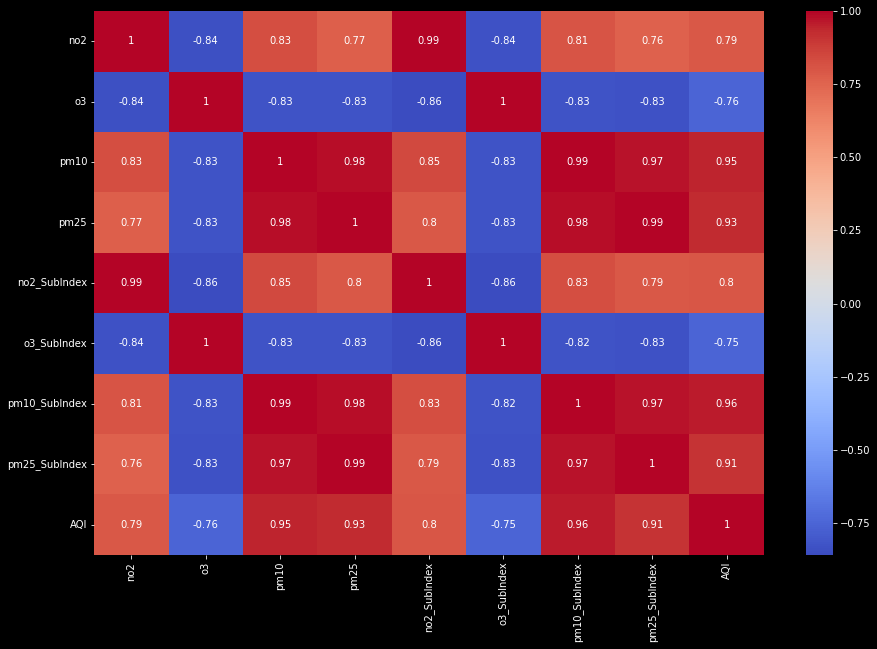

In [485]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(clean_df.corr(),cmap='coolwarm',annot=True)
# plt.savefig('heatmap.png',dpi=400)

In [486]:
clean_df[['location','AQI']].groupby('location').mean().sort_values('AQI').plot(kind='bar')
# plt.savefig('bar.png',dpi=400)

KeyError: "['location'] not in index"

In [ ]:
# clean_df.set_index('date', inplace=True)
clean_df.index = pd.to_datetime(clean_df.index)



In [ ]:
plt.style.use('dark_background')
plt.plot(clean_df.index,clean_df['co'])
plt.xticks(rotation = 45)


KeyError: 'co'

In [ ]:
clean_df.index.hour

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', length=1984)

TEST / SPLIT 

In [ ]:
import requests

# Step 1: Get list of available parameters
response = requests.get('https://api.openaq.org/v1/parameters')
parameters = response.json()['results']
params = ['co','pm10','pm25','so2','o3','no2']
# Step 2: Find parameter ID
parameter_id = None
parameters
# for parameter in parameters:
#     if parameter['id'] == 'pm10':
#         parameter_id = parameter['id']
#         break

# # Step 3: Get measurements for parameter
# response = requests.get(f'https://api.openaq.org/v1/measurements?parameter={parameter_id}&limit=1000')
# measurements = response.json()['results']

# # Step 4: Count number of measurements for each sensor
# sensor_counts = {}
# for measurement in measurements:
#     sensor = measurement['location']
#     if sensor in sensor_counts:
#         sensor_counts[sensor] += 1
#     else:
#         sensor_counts[sensor] = 1

# # Find sensor with most measurements
# most_measurements_sensor = max(sensor_counts, key=sensor_counts.get)
# print(f"The sensor with the most measurements is {most_measurements_sensor} with {sensor_counts[most_measurements_sensor]} measurements.")


[{'id': 1,
  'name': 'pm10',
  'description': 'Particulate matter less than 10 micrometers in diameter mass concentration',
  'preferredUnit': 'µg/m³'},
 {'id': 2,
  'name': 'pm25',
  'description': 'Particulate matter less than 2.5 micrometers in diameter mass concentration',
  'preferredUnit': 'µg/m³'},
 {'id': 3,
  'name': 'o3',
  'description': 'Ozone mass concentration',
  'preferredUnit': 'µg/m³'},
 {'id': 4,
  'name': 'co',
  'description': 'Carbon Monoxide mass concentration',
  'preferredUnit': 'µg/m³'},
 {'id': 5,
  'name': 'no2',
  'description': 'Nitrogen Dioxide mass concentration',
  'preferredUnit': 'µg/m³'},
 {'id': 6,
  'name': 'so2',
  'description': 'Sulfur Dioxide mass concentration',
  'preferredUnit': 'µg/m³'},
 {'id': 7,
  'name': 'no2',
  'description': 'Nitrogen Dioxide concentration',
  'preferredUnit': 'ppm'},
 {'id': 8,
  'name': 'co',
  'description': 'Carbon Monoxide concentration',
  'preferredUnit': 'ppm'},
 {'id': 9,
  'name': 'so2',
  'description': 'S

In [ ]:

# Step 1: Get list of monitoring locations
response = requests.get('https://api.openaq.org/v2/locations?country=PL')
locations = response.json()['results']

# for i in range(len(locations)):
#     if 'Poznań' in locations[i]['name']:
    
#         print(locations[i]['name'])
  
         
# response = requests.get('https://api.openaq.org/v1/latest',params={"country":"PL","city":"Poznań"})
# locations = response.json()
# locations['results']

locations[0]

# for location in locations:
#     if location['cities'][0] == 'Poznań':
#         if len(location['parameters']) >= 1:
#             print(location)
#             print(location['parameters'])
    
    
    


# filtered_locations = {k: v for k, v in location_parameter_counts.items() if v >= 6}

# # Step 4: Extract names of filtered locations
# location_names = list(filtered_locations.keys())

# print(location_names)



# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error,accuracy_score

# # Split the data into training and testing sets
# X = clean_df.drop(['location', 'AQI',"AQI_Bucket"], axis=1)
# y = clean_df['AQI']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a random forest regressor model on the training set
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Use the trained model to make predictions on the test set
# y_pred = rf.predict(X_test)
# y_pred
# # Compute the mean squared error of the predictions
# mse = mean_squared_error(y_test, y_pred)
# print('Mean squared error:', mse)




# response = requests.get('https://api.openaq.org/v2/measurements',params={"country":"PL","city":"Poznań"})
# locations = response.json()
# locations['results'][46]


{'id': 69534,
 'city': None,
 'name': 'Jaruzyn',
 'entity': 'community',
 'country': 'PL',
 'sources': [{'url': 'https://www2.purpleair.com/',
   'name': 'PurpleAir',
   'id': 'purpleair',
   'readme': None,
   'organization': None,
   'lifecycle_stage': None}],
 'isMobile': False,
 'isAnalysis': False,
 'parameters': [{'id': 1150237,
   'unit': 'particles/cm³',
   'count': 1142328,
   'average': 2.16986729730865,
   'lastValue': 3.64,
   'parameter': 'um010',
   'displayName': 'PM1 count',
   'lastUpdated': '2023-03-03T00:59:42+00:00',
   'parameterId': 126,
   'firstUpdated': '2021-01-19T23:58:55+00:00',
   'manufacturers': None},
  {'id': 413892,
   'unit': 'µg/m³',
   'count': 1142328,
   'average': 17.3741480555497,
   'lastValue': 29.3,
   'parameter': 'pm1',
   'displayName': 'PM1',
   'lastUpdated': '2023-03-03T00:59:42+00:00',
   'parameterId': 19,
   'firstUpdated': '2021-01-19T23:58:55+00:00',
   'manufacturers': None},
  {'id': 1150235,
   'unit': 'particles/cm³',
   'count

In [ ]:
pivot_df.isna().sum()

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# # Split the data into training and testing sets
# X = pivot_df.drop(['location','date'], axis=1)
# y = pivot_df[['co', 'no2', 'o3', 'pm10', 'pm25']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a random forest regressor model on the training set
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Use the trained model to make predictions on the test set
# y_pred = rf.predict(X_test)

# # Compute the mean squared error of the predictions
# mse = mean_squared_error(y_test, y_pred)
# print('Mean squared error:', mse)









parameter_name
location       0
date           0
co          3159
no2         1582
o3          1578
pm10        1055
pm25        1056
dtype: int64

In [ ]:
import requests

# Set the API endpoint and parameters
endpoint = "https://api.openaq.org/v1/locations"
params = {
    "country": "PL",
    "city": "Oława",
    "limit": 10000  # Increase the limit to retrieve all sensors
}

# Send a GET request to the API
response = requests.get(endpoint, params=params)

# Parse the response as JSON
data = response.json()


sensor_ids = []

# Loop through each location in the response
for location in data["results"]:
    if 'no2' and 'pm25' and 'pm10' and 'o3' in location['parameters']:
        print(location['id'])
    
    # Check if the location has a parameter called "parameter" that reports NO2, PM10, O3, and PM2.5
    # if all(set(p) in set(["no2", "pm10", "o3", "pm25"]) for p in location["parameters"]):
    # # Add the ID of the sensor to the list
    #     sensor_ids.append(location["id"])

# Print the IDs of sensors that report measurements for all parameters



7264


False